In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_columns', 999)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import ElasticNet

from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# Step 1. Load Data

- data types
- data size

In [2]:
raw_data = pd.read_csv('../data/redfin_cleaned.csv')
data = raw_data.copy()
data = data.loc[data.Price.notna()]
data = data.loc[data.Zip.notna()]
data = data.loc[(data.Longitude.notna()) & (data.Longitude.values!=0)]
data['Zip'] = data.Zip.astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11873 entries, 0 to 12033
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               11873 non-null  int64  
 1   Beds                11861 non-null  float64
 2   SqFt                11873 non-null  float64
 3   Baths               11844 non-null  float64
 4   Address             11873 non-null  object 
 5   City                11873 non-null  object 
 6   Zip                 11873 non-null  int64  
 7   PropertyType        11872 non-null  object 
 8   YearBuilt           11871 non-null  float64
 9   Community           11872 non-null  object 
 10  LotSize             8896 non-null   float64
 11  RedfinEstimate      11694 non-null  float64
 12  PricePerSqFt        11872 non-null  float64
 13  CentralAir          11873 non-null  object 
 14  Fireplace           11873 non-null  object 
 15  Levels              11872 non-null  object 
 16  Main

In [3]:
rows = data.shape[0]
cols = data.shape[1]
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')

Number of rows: 11873
Number of columns: 48


# Step 2. Data Exploration

## 2.1 Explore missingness
- Calculate percent of data are missing in each column.
- Much (at least 50%) of school district information is missing, except for high school information.
- Only keep high school district information

In [4]:
pct_missing = np.round(data.isna().mean(), 2)
colnames = data.columns.values
sorted(zip(pct_missing, colnames), reverse=True)

[(0.65, 'KtoFiveType'),
 (0.65, 'KtoFiveRating'),
 (0.65, 'KtoFiveDist'),
 (0.57, 'SixtoEightType'),
 (0.57, 'SixtoEightRating'),
 (0.57, 'SixtoEightDist'),
 (0.55, 'SeventoEightType'),
 (0.55, 'SeventoEightRating'),
 (0.55, 'SeventoEightDist'),
 (0.55, 'KtoSixType'),
 (0.55, 'KtoSixRating'),
 (0.55, 'KtoSixDist'),
 (0.26, 'TransitScore'),
 (0.25, 'LotSize'),
 (0.08, 'NinetoTwelveType'),
 (0.08, 'NinetoTwelveRating'),
 (0.08, 'NinetoTwelveDist'),
 (0.02, 'RedfinEstimate'),
 (0.01, 'MainLevelBedrooms'),
 (0.01, 'MainLevelBathrooms'),
 (0.01, 'BikeScore'),
 (0.0, 'Zip'),
 (0.0, 'YearBuilt'),
 (0.0, 'WalkScore'),
 (0.0, 'WalkInCloset'),
 (0.0, 'SqFt'),
 (0.0, 'Spa'),
 (0.0, 'PropertyType'),
 (0.0, 'PricePerSqFt'),
 (0.0, 'Price'),
 (0.0, 'Pool'),
 (0.0, 'Patio'),
 (0.0, 'ParkingSpaces'),
 (0.0, 'Longitude'),
 (0.0, 'Levels'),
 (0.0, 'Latitude'),
 (0.0, 'KitchenIsland'),
 (0.0, 'HighCeiling'),
 (0.0, 'GarageSpaces'),
 (0.0, 'Fireplace'),
 (0.0, 'Community'),
 (0.0, 'CommonWalls'),
 (0.0, '

In [5]:
drop_cols = ['KtoFiveType',
             'KtoSixType',
             'NinetoTwelveType',
             'SeventoEightType',
             'SixtoEightType',
             'SixtoEightRating',
             'SixtoEightDist',
             'KtoSixRating',
             'KtoSixDist',
             'SeventoEightRating',
             'SeventoEightDist',
             'KtoFiveRating',
             'KtoFiveDist']
data.drop(drop_cols, axis=1, inplace=True)

## 2.2 Drop some categorical features categorical

I drop the following features:
- Address
- City
- Community

Features such as city and community are important determinants of home prices. However, I do not have enough sample size to incorporate them in the analysis.

I also drop Redfin estimate and sale price per sqft since these data will not be used.

I keep zip code for imputation purposes. For the imputation to make sense, we need sufficient number of observations for each zip code. I drop any zip codes with fewer than 30 observations.

In [6]:
drop_cols = ['Address',
             'City',
             'Community',
             'RedfinEstimate',
             'PricePerSqFt']
data.drop(drop_cols, axis=1, inplace=True)

In [7]:
zip_list = data['Zip'].value_counts().to_frame()
zip_list['ZipCount'] = zip_list['Zip']
zip_list['Zip'] = zip_list.index
zip_list

data = data.merge(zip_list, on='Zip')
data = data.loc[data['ZipCount']>100]
data.drop('ZipCount', axis=1, inplace=True)
data.shape

(10302, 30)

## 2.3  Visualize variable distributions 

- Find that price is highly skewed
- Identified several outliers (high price, high sqft, high lot size)
- Most homes were built between 1970 and 2000s
- Walk score is somewhat uniformly distributed
- Transit score is bimodal
- Bike score is somewhat skewed

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Beds'}>,
        <AxesSubplot:title={'center':'SqFt'}>,
        <AxesSubplot:title={'center':'Baths'}>],
       [<AxesSubplot:title={'center':'Zip'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'LotSize'}>,
        <AxesSubplot:title={'center':'MainLevelBathrooms'}>],
       [<AxesSubplot:title={'center':'MainLevelBedrooms'}>,
        <AxesSubplot:title={'center':'GarageSpaces'}>,
        <AxesSubplot:title={'center':'ParkingSpaces'}>,
        <AxesSubplot:title={'center':'Latitude'}>],
       [<AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'NinetoTwelveRating'}>,
        <AxesSubplot:title={'center':'NinetoTwelveDist'}>,
        <AxesSubplot:title={'center':'WalkScore'}>],
       [<AxesSubplot:title={'center':'TransitScore'}>,
        <AxesSubplot:title={'center':'BikeScore'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dt

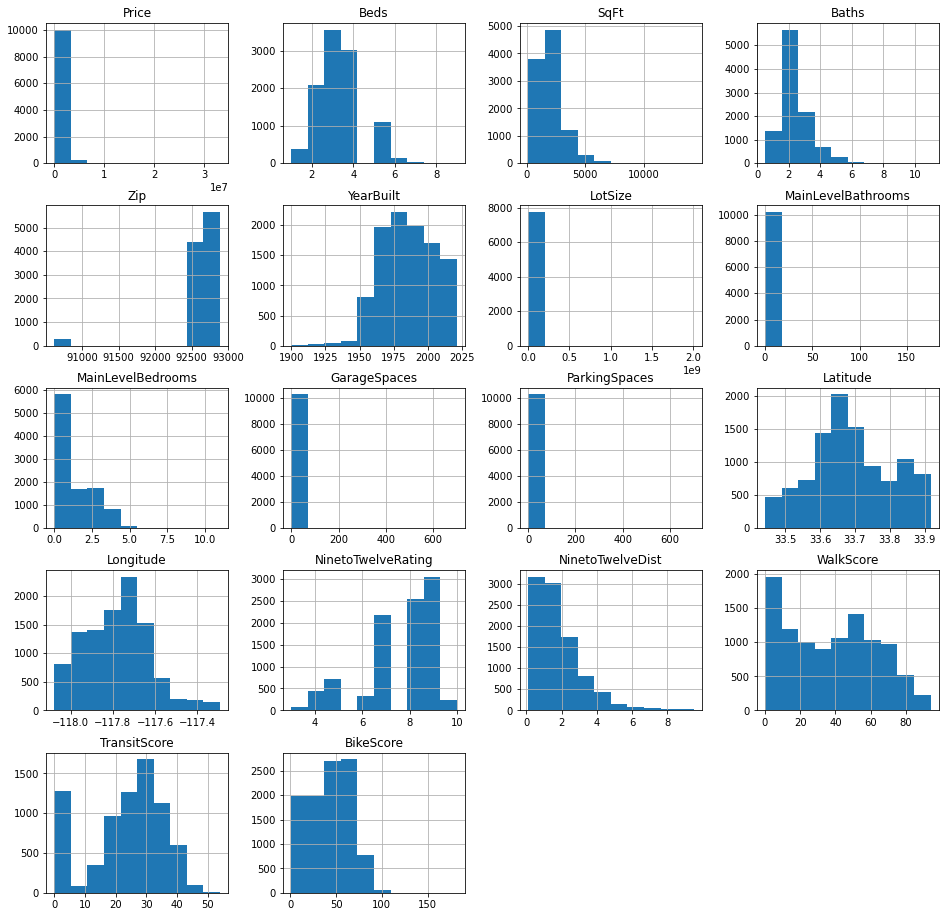

In [8]:
data.hist(figsize=(16,16))

### Remove outliers

##### Rule-based:
- Transform highly skewed continuous variables.
- Define outliers as any observations three standard deviation (in absolute value) away from the mean.
- These outliers are likely to be beach-front masions and are not the target population.

##### Manual:
- Inspect and remove remaining outliers that are likely due to human imputation errors.

In [9]:
cols = ['Price', 'SqFt', 'LotSize',
        'GarageSpaces','ParkingSpaces',
        'MainLevelBathrooms','MainLevelBedrooms',
        'BikeScore','TransitScore', 'WalkScore']
outlier_data = pd.DataFrame(index=data.index)

for col in cols:
    std = (data[col].values - data[col].mean())/data[col].std()
    outlier_data[col] = std
outlier_index = outlier_data.index[(np.abs(outlier_data)>3).any(axis=1)]

data = data.drop(outlier_index, axis=0)

### Price and square footage

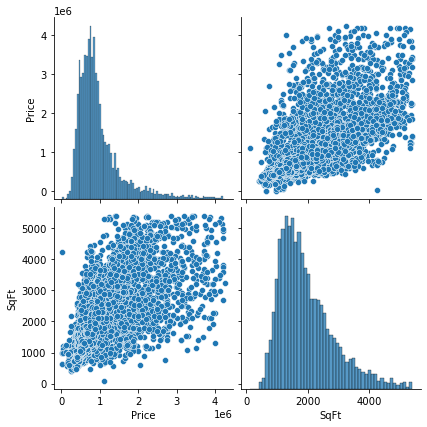

In [10]:
cols = ['Price','SqFt']
sns.pairplot(data[cols], vars=cols, height=3)

### Price and lot size

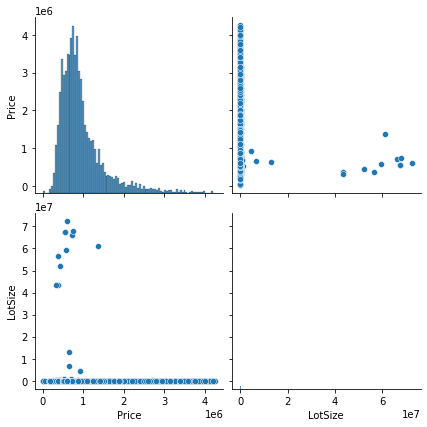

In [11]:
cols = ['Price','LotSize']
sns.pairplot(data[cols], vars=cols, height=3)

### Garage spaces and parking spaces

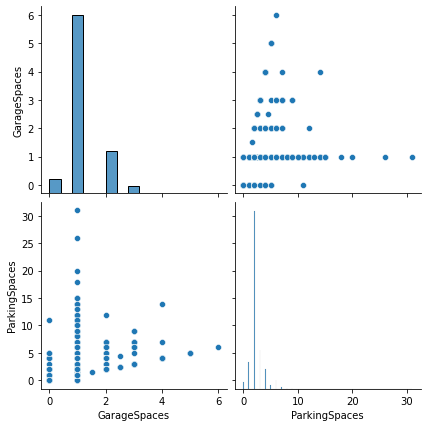

In [12]:
cols = ['GarageSpaces','ParkingSpaces']
sns.pairplot(data[cols], vars=cols, height=3)

### Main level bathrooms and main level bedrooms

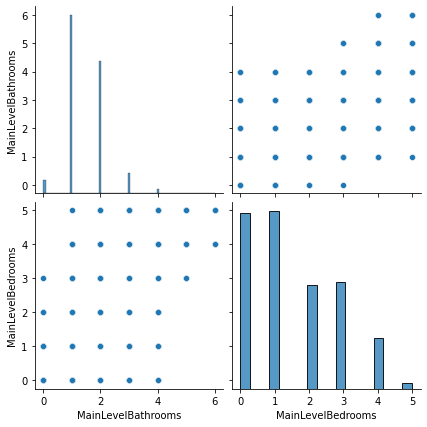

In [13]:
cols = ['MainLevelBathrooms','MainLevelBedrooms']
sns.pairplot(data[cols], vars=cols, height=3)

### Bike, transit, and walkability scores

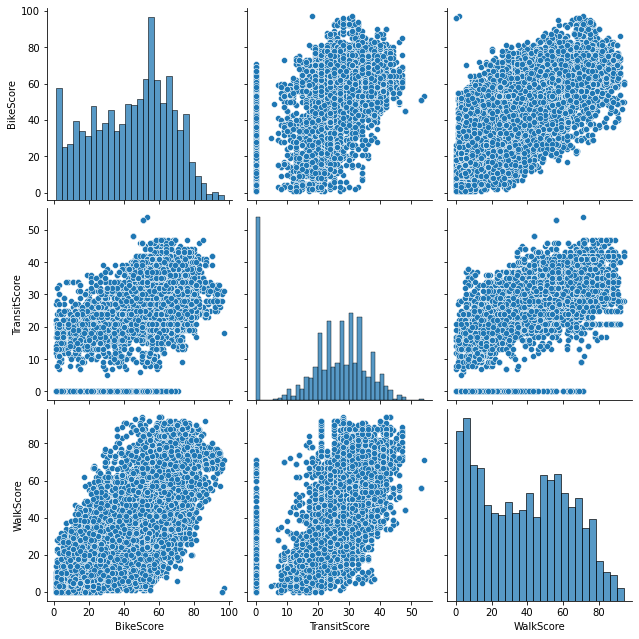

In [14]:
cols = ['BikeScore','TransitScore', 'WalkScore']
sns.pairplot(data[cols], vars=cols, height=3)

In [15]:
idx = data.index[data['LotSize']>0.3 * 1e6].values
data.drop(index=idx, inplace=True)

idx = data.index[data['ParkingSpaces']>10].values
data.drop(index=idx, inplace=True)

# Step 3. Feature Selection and Engineering

## 3.1 Encode and bin some categorical features
- Convert number of common walls from string to numeric
- Combine multi/split-level homes with homes with three or more levels
- Create "PrivateSpa" indicator from "Spa" indicator (dropping "Association Spa" category)
- Create "PrivatePool" indicator from "Pool" indicator (dropping "Association Pool" category)
- Create interaction between latitude and longitude "LatLon" 

In [16]:
data['CommonWalls'] = data['CommonWalls'].map({'No Common Wall':0,
                                               '1 Common Wall':1,
                                               '2+ Common Walls':2})
data['Levels'].replace({'Multi/Split':'Three Or More'}, inplace=True)
data['PrivateSpa'] = data['Spa']=='Private'
data['PrivatePool'] = data['Pool']=='Private'
data.drop(['Spa', 'Pool'], axis=1, inplace=True)

## 3.2 Imputation
- Imputing missing numeric variables with sample median.
- Impute missing categorical variables with sample mode.

Before proceeding further, first split data into training and testing datasets to avoid data leakage.

In [17]:
rng = np.random.RandomState(17)
test_size = 0.2
data_train, data_test = train_test_split(data,
                                         random_state=rng,
                                         test_size=test_size)

### Impute training set

In [18]:
cols_missing_value = data_train.columns[data_train.isna().sum()>0].values
cols_missing_value
data_train[cols_missing_value].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7957 entries, 8714 to 2216
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Beds                7952 non-null   float64
 1   Baths               7937 non-null   float64
 2   PropertyType        7956 non-null   object 
 3   YearBuilt           7955 non-null   float64
 4   LotSize             5942 non-null   float64
 5   MainLevelBathrooms  7882 non-null   float64
 6   MainLevelBedrooms   7880 non-null   float64
 7   CommonWalls         7954 non-null   float64
 8   NinetoTwelveRating  7409 non-null   float64
 9   NinetoTwelveDist    7409 non-null   float64
 10  WalkScore           7951 non-null   float64
 11  TransitScore        5776 non-null   float64
 12  BikeScore           7894 non-null   float64
dtypes: float64(12), object(1)
memory usage: 870.3+ KB


In [19]:
missing_num_att = data_train[cols_missing_value].select_dtypes(exclude='object').columns
for att in missing_num_att:
    data_train[att].fillna(data_train[att].median(), inplace=True)
    
missing_cat_att = data_train[cols_missing_value].select_dtypes(include='object').columns
for att in missing_cat_att:
    data_train[att].fillna(data_train[att].mode()[0], inplace=True)
    
data_train[cols_missing_value].isna().sum()

Beds                  0
Baths                 0
PropertyType          0
YearBuilt             0
LotSize               0
MainLevelBathrooms    0
MainLevelBedrooms     0
CommonWalls           0
NinetoTwelveRating    0
NinetoTwelveDist      0
WalkScore             0
TransitScore          0
BikeScore             0
dtype: int64

### Impute the test set

In [20]:
cols_missing_value = data_test.columns[data_test.isna().sum()>0].values
cols_missing_value
data_test[cols_missing_value].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 810 to 10841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Beds                1986 non-null   float64
 1   Baths               1988 non-null   float64
 2   LotSize             1475 non-null   float64
 3   MainLevelBathrooms  1974 non-null   float64
 4   MainLevelBedrooms   1973 non-null   float64
 5   CommonWalls         1987 non-null   float64
 6   NinetoTwelveRating  1865 non-null   float64
 7   NinetoTwelveDist    1865 non-null   float64
 8   WalkScore           1989 non-null   float64
 9   TransitScore        1436 non-null   float64
 10  BikeScore           1975 non-null   float64
dtypes: float64(11)
memory usage: 186.6 KB


In [21]:
missing_num_att = data_test[cols_missing_value].select_dtypes(exclude='object').columns
for att in missing_num_att:
    data_test[att].fillna(data_test[att].median(), inplace=True)
    
missing_cat_att = data_test[cols_missing_value].select_dtypes(include='object').columns
for att in missing_cat_att:
    data_test[att].fillna(data_test[att].mode()[0], inplace=True)
    
data_test[cols_missing_value].isna().sum()

Beds                  0
Baths                 0
LotSize               0
MainLevelBathrooms    0
MainLevelBedrooms     0
CommonWalls           0
NinetoTwelveRating    0
NinetoTwelveDist      0
WalkScore             0
TransitScore          0
BikeScore             0
dtype: int64

## 3.3 Feature transformation
- Log transform sale price
- Log transform highly skewed features
    - Square footage
    - Lot size
    - Distance to school
    - Walkability score
    - Transit sore
    - Bike score

In [22]:
cols = ['Price', 
        'SqFt',
        'LotSize', 
        'NinetoTwelveDist', 
        'WalkScore', 
        'TransitScore',
        'BikeScore']
for col in cols:
    data_train[col] = np.log1p(data_train[col].values)
    data_test[col]  = np.log1p(data_test[col].values)

## 3.4 Further encoding
- Encode ordinal data using ordinal encoder
- Encode categorical data using target encoding

In [23]:
num_att = ['Beds','SqFt','Baths', 'YearBuilt', 'LotSize',
           'MainLevelBathrooms','MainLevelBedrooms','GarageSpaces',
           'ParkingSpaces','Latitude','Longitude','NinetoTwelveRating',
           'NinetoTwelveDist','WalkScore','TransitScore','BikeScore',
           'CommonWalls']

cat_att = ['PropertyType','CentralAir','Fireplace',
           'Levels','Patio','WalkInCloset',
           'KitchenIsland','CloseToOutdoors','HighCeiling',
           'PrivateSpa','PrivatePool', 'Zip']

features = num_att + cat_att
features

['Beds',
 'SqFt',
 'Baths',
 'YearBuilt',
 'LotSize',
 'MainLevelBathrooms',
 'MainLevelBedrooms',
 'GarageSpaces',
 'ParkingSpaces',
 'Latitude',
 'Longitude',
 'NinetoTwelveRating',
 'NinetoTwelveDist',
 'WalkScore',
 'TransitScore',
 'BikeScore',
 'CommonWalls',
 'PropertyType',
 'CentralAir',
 'Fireplace',
 'Levels',
 'Patio',
 'WalkInCloset',
 'KitchenIsland',
 'CloseToOutdoors',
 'HighCeiling',
 'PrivateSpa',
 'PrivatePool',
 'Zip']

In [24]:
scaler = StandardScaler()

def cat_encoder(df, att):
    '''
    Target encoding:
    replace categorical values with mean 
    sale price by category
    '''
    impute_dict = df.groupby(att).agg({'Price':'mean'}).to_dict()
    df[att] = df[att].map(impute_dict['Price'])
    return df[att]

def feature_engineering(df, num_att, cat_att):
    
    '''
    numerical att:
    return numerical columns
    '''
    numerical_data = df[num_att].to_numpy()

    '''
    non-ordinal categorical encoder:
    return cateogrical columns
    '''
    for att in cat_att:
        cat_encoder(df, att)
    categorical_data = df[cat_att].to_numpy().copy()
    
    
    '''
    combine and scale features
    '''
    X = np.concatenate([numerical_data, categorical_data], axis=1)
    X = scaler.fit_transform(X)
    y = df['Price'].values 
    return X, y
    
X_train_prep, y_train = feature_engineering(data_train, num_att, cat_att)
X_test_prep, y_test = feature_engineering(data_test, num_att, cat_att)

# Step 4. Models

I will experiment with the following models:
- Regression (ElasticNet)
- Tree-based model (XGBoost)
- Support vector machine

Training evaluation will be based on the mean RMSE of a 5-fold cross-validation exercise.

## 4.0 Build a RMSE scorer

In [25]:
# RMSE scorer
def get_rmse(y_test, y_predict):
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    return rmse

# Initialize RMSE scorer
rmse_scorer = make_scorer(get_rmse, greater_is_better=False)

# K-Fold cross-validation RMSE
rng = np.random.RandomState(17)
kfolds = KFold(n_splits=5, shuffle=True, random_state=rng)
def cv_rmse(model, X, y):
    cv_rmse = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kfolds)
    return cv_rmse

## 4.1 Regression

In [26]:
def ElasticNet_fn(params):
    
    params = {'alpha': params['alpha'],
              'l1_ratio': params['l1_ratio']}
     
    model = ElasticNet(random_state=rng, max_iter=1e6, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

### Hyperparameter tunining

In [27]:
space = {'alpha' : hp.uniform('alpha', low=0, high=2),
         'l1_ratio' : hp.uniform('l1_ratio', low=0, high=1),}

trials = Trials()
ElasticNet_best_params = fmin(fn=ElasticNet_fn, 
                              space=space, 
                              algo=tpe.suggest, 
                              max_evals=25*5,
                              trials=trials, 
                              rstate=rng)
pickle.dump(ElasticNet_best_params, open("../output/ElasticNet.pkl", "wb"))

100%|██████████| 125/125 [00:04<00:00, 30.53trial/s, best loss: 0.2058350879385528]


### Coefficient / RMSE score

In [28]:
ElasticNet_fn_score = ElasticNet_fn(ElasticNet_best_params)
ElasticNet_table = ElasticNet_best_params.copy()
ElasticNet_table['Score'] = ElasticNet_fn_score
pd.DataFrame(ElasticNet_table.values(), 
             index=ElasticNet_table.keys(), 
             columns=['Parameters / Score'])

,Parameters / Score
alpha,0.001568
l1_ratio,0.400893
Score,0.206227


### Plot coefficients

In [29]:
ElasticReg_best = ElasticNet(random_state=rng, **ElasticNet_best_params)
ElasticReg_best.fit(X_train_prep, y_train)
plot_data = pd.DataFrame(zip(features, ElasticReg_best.coef_), 
                         columns=['Feature','Coefficient'])
plot_data = plot_data.sort_values(by='Coefficient',
                                  ascending=False,
                                  key = lambda x: np.abs(x))

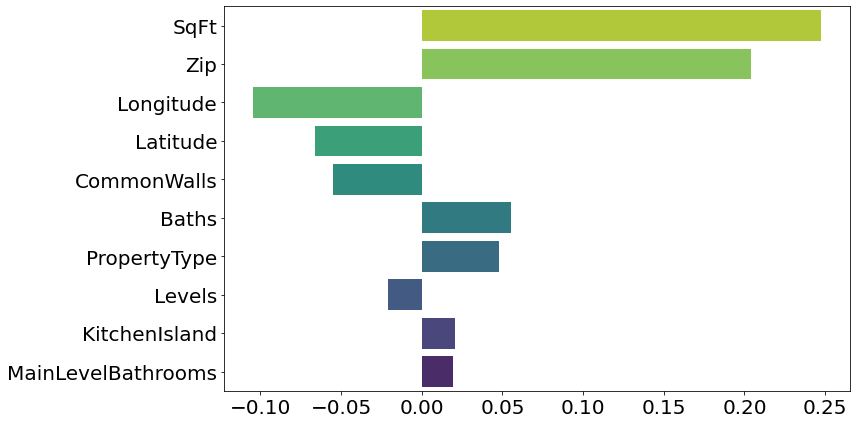

In [30]:
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.iloc[0:10,], 
            y='Feature', 
            x='Coefficient',
            palette='viridis_r')
#ax.set_title('Elastic Net Feature Coefficients', size=30)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()
f.savefig('../output/figure_ElasticNet.pdf')

## 4.2 Tree-based models

In [31]:
def XGBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

### Hyperparameter Tuning

In [32]:
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=5000, q=500),
         'max_depth' : hp.quniform('max_depth', low=2, high=10, q=1),
         'learning_rate': hp.uniform('learning_rate', low=0.01, high=0.1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.2, high=0.8),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.5),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=1),}

trials = Trials()
XGBR_best_params = fmin(fn=XGBR_fn, 
                        space=space, 
                        algo=tpe.suggest, 
                        max_evals=25*5,
                        trials=trials, 
                        rstate=rng)
pickle.dump(XGBR_best_params, open('../output/XGBR.pkl', 'wb'))

100%|██████████| 125/125 [1:09:27<00:00, 33.34s/trial, best loss: 0.12493703785033845]


### Feature importance / RMSE score

In [33]:
XBGR_fn_score = XGBR_fn(XGBR_best_params)
XGBR_best_params['max_depth']=int(XGBR_best_params['max_depth'])
XGBR_best_params['min_child_weight']=int(XGBR_best_params['min_child_weight'])
XGBR_best_params['n_estimators']=int(XGBR_best_params['n_estimators'])
XGBR_table = XGBR_best_params.copy()
XGBR_table['Score'] = XBGR_fn_score
pd.DataFrame(XGBR_table.values(), 
             index=XGBR_table.keys(), 
             columns=['Parameters / Score'])

,Parameters / Score
colsample_bytree,0.465440
learning_rate,0.013772
max_depth,8.000000
min_child_weight,5.000000
n_estimators,2500.000000
reg_alpha,0.157344
reg_lambda,0.523062
subsample,0.576397
Score,0.127335


### Plot feature importance

In [34]:
XGBR_best = XGBRegressor(random_state=rng, **XGBR_best_params)
XGBR_best.fit(X_train_prep, y_train)
plot_data = pd.DataFrame(zip(features, XGBR_best.feature_importances_), 
                    columns=['Feature','Importance'])
plot_data = plot_data.sort_values(by='Importance',
                                  ascending=False,
                                  key = lambda x: np.abs(x))

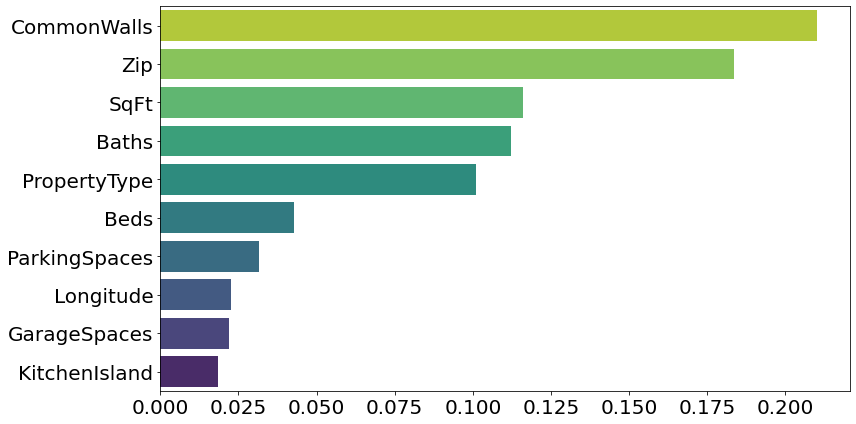

In [35]:
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(data=plot_data.iloc[0:10,],
                 y='Feature', 
                 x='Importance', 
                 palette='viridis_r')
#ax.set_title('Feature Importance Index (% of Max)', size=30)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()
f.savefig('../output/figure_XGBoost.pdf')

## 4.3 Support vector regressor

In [38]:
def LinearSVR_fn(params):
    
    params = {'C':params['C']}
    
    model = LinearSVR(max_iter=1e5, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

### Hyperparameter tuning

In [39]:
space = {'C' : hp.uniform('C', low=0.001, high=1)}
trials = Trials()
LinearSVR_best_params = fmin(fn=LinearSVR_fn, 
                             space=space, 
                             algo=tpe.suggest, 
                             max_evals=25*5,
                             trials=trials, 
                             rstate=rng)
pickle.dump(LinearSVR_best_params, open('../output/LinearSVR.pkl', 'wb'))

100%|██████████| 125/125 [04:23<00:00,  2.11s/trial, best loss: 0.2079026814396226]


### Coefficient / RMSE score

In [40]:
LinearSVR_fn_score = LinearSVR_fn(LinearSVR_best_params)
LinearSVR_table = LinearSVR_best_params.copy()
LinearSVR_table['Score'] = LinearSVR_fn_score
pd.DataFrame(LinearSVR_table.values(), 
             index=LinearSVR_table.keys(), 
             columns=['Parameters / Score'])

,Parameters / Score
C,0.247663
Score,0.208516


### Plot feature coefficient

In [41]:
LinearSVReg_best = LinearSVR(random_state=rng, max_iter=1e5, **LinearSVR_best_params)
LinearSVReg_best.fit(X_train_prep, y_train)
plot_data = pd.DataFrame(zip(features, LinearSVReg_best.coef_), 
                    columns=['Feature','Coefficient'])
plot_data = plot_data.sort_values(by='Coefficient',
                                  ascending=False, 
                                  key = lambda x: np.abs(x))

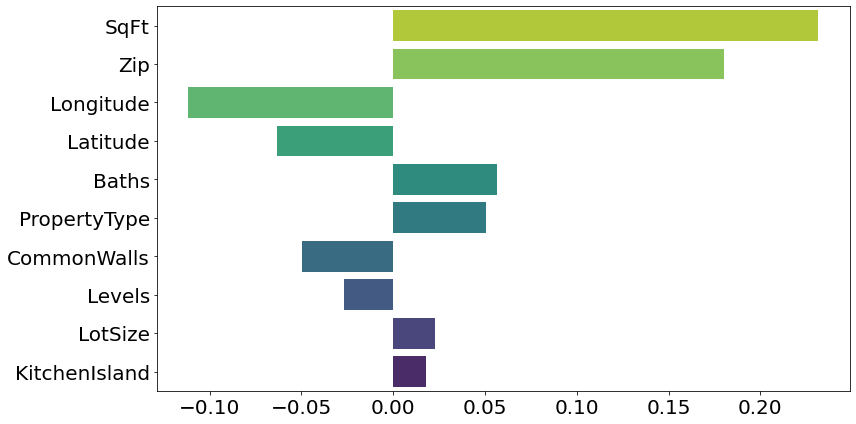

In [42]:
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.iloc[0:10,], 
            y='Feature', 
            x='Coefficient',
            palette='viridis_r')
#ax.set_title('Linear SVR Feature Coefficients', size=30)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()
f.savefig('../output/fig_LinearSVR.pdf')

# 5. Test Model

Report RMSE of the models using the test set.

In [43]:
models = {'ElasticReg': ElasticReg_best, 'XGBR':XGBR_best, 'LinearSVReg':LinearSVReg_best}
def test_model(model):
    y_predict = model.predict(X_test_prep)
    rmse = get_rmse(y_test, y_predict)
    return rmse

results = dict()
for name, model in models.items():
    results[name] =  test_model(model)
    
pd.DataFrame(results.values(), index=results.keys(), columns=['Score'])

,Score
ElasticReg,0.201489
XGBR,0.137059
LinearSVReg,0.201158
